In [11]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# 30 sec

In [12]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [13]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [14]:
csvs_medium_track_vs_cascade = {
    r"$\nu_{\mu}$ vs. $\nu_e$, E$\in$(10TeV,1PeV), train(250m), val(250m)": "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250411/model_20250410_120945/100731/predictions_epoch_010_val_loss_0.0855.csv",
}

In [20]:
def get_neutrino_logits(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["logits"] = df["logits"].apply(safe_parse)

    neutrino_mu = df[df["target_class"] == 1]["logits"]
    neutrino_e = df[df["target_class"] == 0]["logits"]

    logit_neutrino_mu = neutrino_mu.apply(lambda x: x[1]).to_numpy()
    logit_neutrino_e = neutrino_e.apply(lambda x: x[1]).to_numpy()

    return logit_neutrino_mu, logit_neutrino_e

In [37]:
def plot_logit_distribution(df: pd.DataFrame, 
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    logit_neutrino_mu, logit_neutrino_e = get_neutrino_logits(df)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(logit_neutrino_mu, binwidth=0.01)
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(logit_neutrino_mu, bins=bins, label=r'$\nu_{\mu}$', color=getColour(0), histtype='step', linewidth=2)
    ax.hist(logit_neutrino_e, bins=bins, label=r'$\nu_e$', color=getColour(2), histtype='step', hatch='\\', linewidth=2)
    
    
    ax.set_title(fr"logit $\nu_\mu$ distribution of {id}")


    ax.set_xlabel('Logit')
    ax.set_ylabel('Counts')
    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.1)
    d_mu = {
        r'$\nu_{\mu}$': "",
        "N": len(logit_neutrino_mu),
        "mean": f"{np.mean(logit_neutrino_mu):.3f}",
        "median": f"{np.median(logit_neutrino_mu):.3f}",
        "max": f"{np.max(logit_neutrino_mu):.3f}",
        "min": f"{np.min(logit_neutrino_mu):.3f}",
        }
    d_e = {
        r'$\nu_e$': "",
        "N": len(logit_neutrino_e),
        "mean": f"{np.mean(logit_neutrino_e):.3f}",
        "median": f"{np.median(logit_neutrino_e):.3f}",
        "max": f"{np.max(logit_neutrino_e):.3f}",
        "min": f"{np.min(logit_neutrino_e):.3f}",
        }
    add_text_to_ax(0.2, 0.95, nice_string_output(d_mu), ax, fontsize=12)
    add_text_to_ax(0.2, 0.75, nice_string_output(d_e), ax, fontsize=12)

    ax.legend()

In [50]:
def plot_ROC(df: pd.DataFrame, id: str) -> None:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x
    df["logits"] = df["logits"].apply(safe_parse)

    # Muon neutrino is class 1
    y_true = df["target_class"].to_numpy()
    y_scores = df["logits"].apply(lambda x: x[1]).to_numpy()  # ← nu_mu score!

    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(17, 11))
    ax.plot(fpr, tpr, label=fr"ROC curve for $\nu_\mu$ (AUC = {roc_auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(fr"ROC Curve: {id}")
    ax.legend()

In [51]:
def plot_csvs(csvs:dict, is_magnifier_on:bool):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_logit_distribution(df, id)
        plot_ROC(df, id)
        # print(df[['target_class','pred_class','target_one_hot_pid','logits']].head())
        # print(get_neutrino_signal_logits(df)[0])

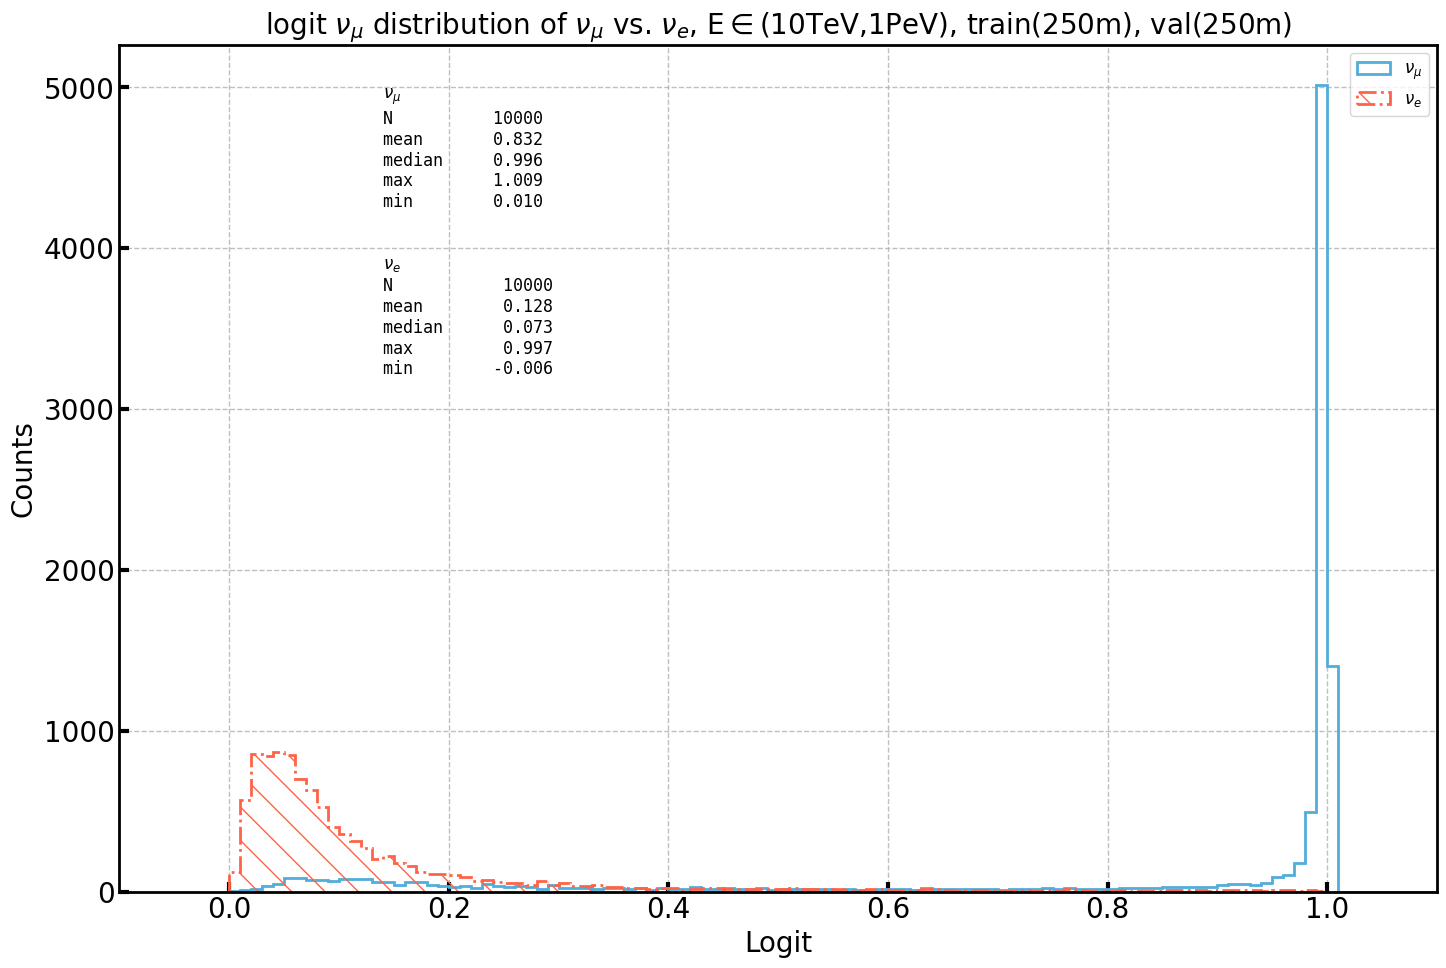

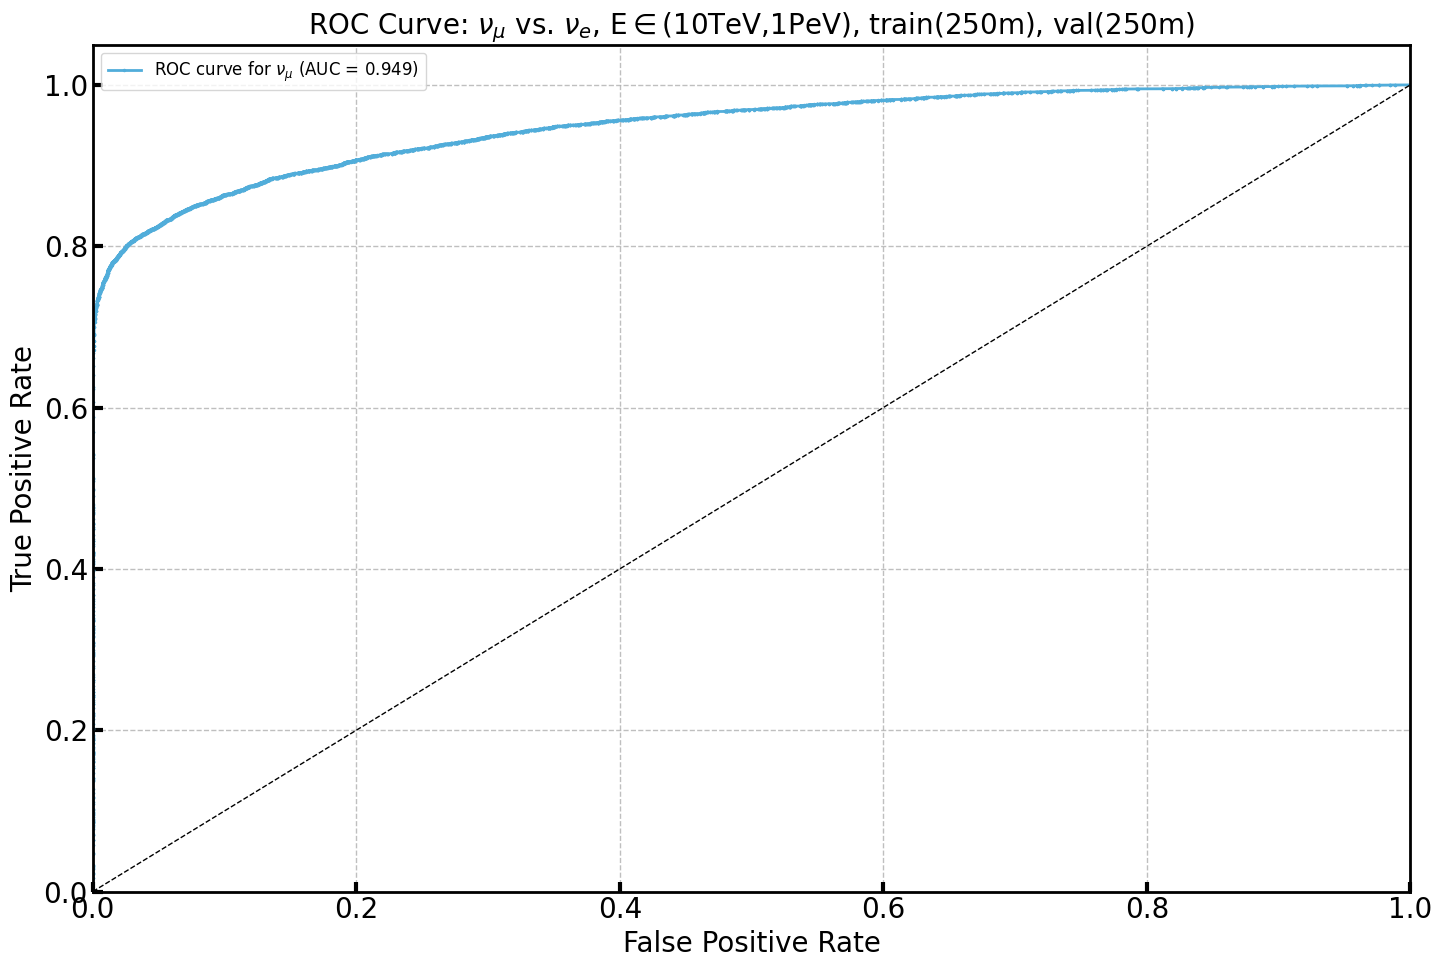

In [52]:
plot_csvs(csvs_medium_track_vs_cascade, False)